# Assignment 3

## Lectures 5 & 6 - Non-parametric methods and deep learning



# Table of Contents
1. [Decision trees](#Decision-trees)
2. [Artifical neural networks (ANN)](#Artifical-neural-networks-(ANN))

# General Instructions
- Jupyter notebook is supposed to be run cell by cell in order, please do not skip any code cell, this will cause some errors. Also running cells back and forth sometimes might also incur errors. If you feel you lost your track, you can click "Kernel->Restart" from the menu to restart the process.
- Before submitting your assignment, ensure that it does not contain trivial errors by pressing the "validate" button at the top.
- Your implementations are supposed to be added to the places where it reads "YOUR CODE HERE". Please also remove the "raise NotImplementedError()" line before submitting.
- Please DO NOT change the metadata of any cell, cells for demo and instructions are not editable.
- Please DO NOT change the order of solution cell and test cell, you will lost points if the order is changed.
- You can copy lines of code from cells that are not editable, but please DO NOT copy and paste them as cells, this may incur validation error. 
- You can add extra cells or code to help double-check your solution, but please make sure that variables required by tasks are not overwritten, or just delete those extra cells before submitting.
- Please DO NOT change file names in you submission, renamed files can not be recognized by the grading system.
- Reading the documentation of Python libraries is always a good practice, all the Python libraries (Numpy, Pandas, Sklearn,etc.) we utilized in this course provide very well organized documentation for each method/class/function.

In [9]:
%config Completer.use_jedi = False  # enable code auto-completion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_text, plot_tree, DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.preprocessing import PolynomialFeatures   
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score    


# Decision trees

### Learning goals
- To train and fit a decision tree classifier
- To be able to assess the accuracy of a decision tree
- To interpret a decision tree

A decision tree is a non-parametric method used in classification and regression tasks. In this exercise, you will train a decision tree classifier to assess the edibility of mushrooms.

### The Data

This dataset is from https://archive.ics.uci.edu/ml/datasets/Mushroom. From the data description: "*This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one.*"

For convenience, the original data has been modified to accomodate more human-readable categories and features and saved as `mushroom_data.csv`.

Your goal is to build a classifier for these mushroom species, with edibility as a label. Is it possible to tell apart poisonous mushrooms from edible ones based on the data?

First, let's store the data into a pandas `DataFrame` and take a look at it.

In [4]:
data = pd.read_csv("mushroom_data.csv") # read the data
print(data.shape)
data.head()

(8123, 22)


,y,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,edible,convex,smooth,yellow,1,almond,free,close,broad,black,...,smooth,smooth,white,white,white,1,pendant,brown,numerous,grasses
1,edible,bell,smooth,white,1,anise,free,close,broad,brown,...,smooth,smooth,white,white,white,1,pendant,brown,numerous,meadows
2,poisonous,convex,scaly,white,1,pungent,free,close,narrow,brown,...,smooth,smooth,white,white,white,1,pendant,black,scattered,urban
3,edible,convex,smooth,gray,0,none,free,crowded,broad,black,...,smooth,smooth,white,white,white,1,enanescent,brown,abundant,grasses
4,edible,convex,scaly,yellow,1,almond,free,close,broad,brown,...,smooth,smooth,white,white,white,1,pendant,black,numerous,grasses


### Visualization

Next, we can visualize the data. For count data, a barplot would be a good starting point. Here, we are using the `seaborn` library's [countplot()](https://seaborn.pydata.org/generated/seaborn.countplot.html) function. We can see that the labels are quite evenly distributed.

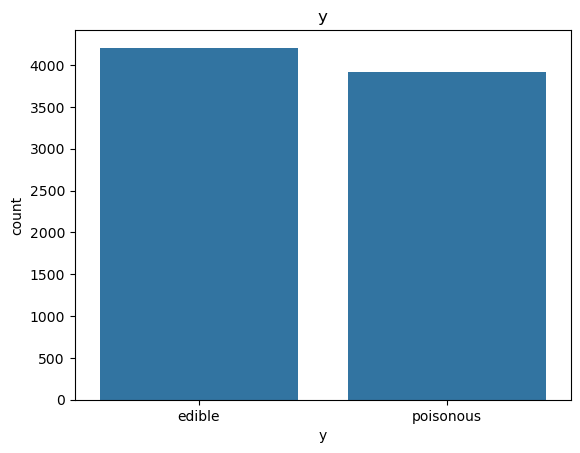

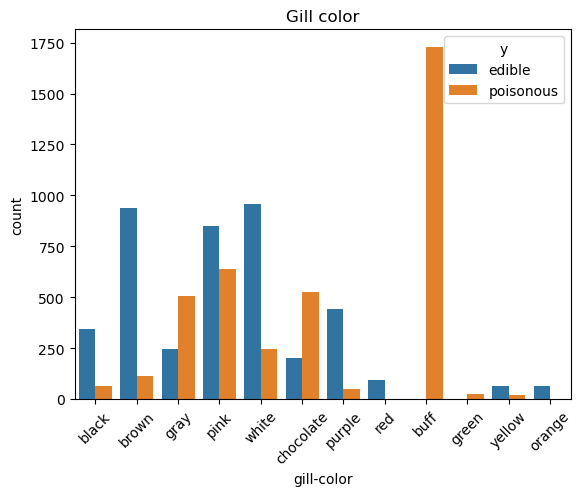

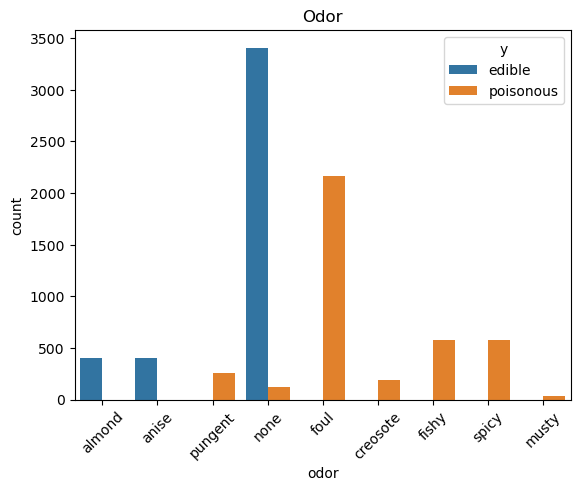

In [5]:
# Visualize the label
sns.countplot(x = "y", data = data)
plt.title("y")
plt.show()

# Choose some features to visualize
sns.countplot(x = "gill-color", data = data, hue = "y")
plt.xticks(rotation = 45)
plt.title("Gill color")
plt.show()

sns.countplot(x = "odor", data = data, hue = "y")
plt.xticks(rotation = 45)
plt.title("Odor")
plt.show()

### Fitting the classifier

We will use sklearn's DecisionTreeClassifier to construct a decision tree from our data. Check scikit-learn's tutorial on [Decision Trees](https://scikit-learn.org/stable/modules/tree.html) for additional information and inspiration for your future projects.

First, extract features $X$ and labels $y$ from the data and encode edibility (label $y$) of the mushroom $i$ as $y_i \in \{0,1\}$:

In [6]:
y = np.where(data['y'] == "edible", 1, 0) # encode edibility as 1 or 0

X = data[data.columns]
X = X.drop(columns = ["y"]) # drop the label

y # take a look

array([1, 1, 0, ..., 1, 0, 1])

Then, we need to encode the categorical variables: DecisionTreeClassifier cannot handle categorical features unless they are binary. For this, we use [one-hot encoding](https://en.wikipedia.org/wiki/One-hot).

In short, one-hot encoding takes a categorical feature/variable and changes it into 0s and 1s - even if the feature has more than two unique categories. For example, if feature $a$ (let's say, mushroom cap color) has observations belonging in categories $a \in \{yellow, pink, blue\}$, we could encode these as features $a_{yellow}, a_{pink}, a_{blue}$. An observation $i$ is now associated with these three features, and will have a value of 1, if the observation is of that group and 0 for others. Below, we have an example data set of four observations before and after one-hot encoding:

Before one-hot encoding:
$$\mathbf{a} = \begin{bmatrix}"yellow"\\"pink"\\"blue"\\"blue"\end{bmatrix}$$

After one-hot encoding:
$$\mathbf{a}_{yellow} = \begin{bmatrix} 1\\ 0\\0\\0\end{bmatrix}, \mathbf{a}_{pink} = \begin{bmatrix} 0\\ 1\\0\\0\end{bmatrix}, \mathbf{a}_{blue} = \begin{bmatrix} 0\\ 0\\1\\1\end{bmatrix}$$
    


As you can see, this increases the number of features in the data, but will allow us to work with only ones and zeros. This in turn makes it possible to for example plot a heatmap - and use DecisionTreeClassifier, which only supports continous or binary variables.


Here, we are using pandas function [get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) for one-hot encoding.


In [7]:
X = pd.get_dummies(X, dtype = int)
print(X.shape)
X.head()

(8123, 113)


,bruises,ring-number,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,...,population_scattered,population_several,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


We would also like to know how well our classifier performs on unseen data - could we actually use our classifier to predict edibility of a mushroom we found in the woods? For this, we will divide our data into training and test sets. The training set will be used to train our classifier, and we'll test its predictive ability on the test set, which will act as our approximation of new data. [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function from scikit-learn can be used to easily perform the split to train and test set.

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=2)

print(X_train.shape)
print(X_test.shape)

(5442, 113)
(2681, 113)


<div class=" alert alert-warning">

## Student Task A3.1

Now we can fit the decision tree classifier. Your task is to use [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) from scikit-learn. **Set random_state = 0 and max_depth = 2.**

1. Fit a decision tree classifier
    - As before in classification/regression assignments:
        1. Create a classifier object
        2. Call the fit method
        3. Call the predict method
    
    
</div> 

In [9]:
# Fit and train the DecisionTreeClassifier() using the training data. Predict on the test set. 
# Set random_state = 0.

# clf = ...  # train using the train data
# clf ...    # fit the classifier
# y_pred = ... # predict for test data

# YOUR CODE HERE
#raise NotImplementedError()
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## sanity check
assert isinstance(clf, DecisionTreeClassifier), "please initialise a DecisionTree classifier"
assert len(y_pred) == len(y_test), "the length of y_pred is incorrect"

In [10]:
# this cell is for tests


<div class=" alert alert-warning">

## Student Task A3.2

Hint: relevant sklearn functions have been imported for you.
    
1. Compute the accuracy of the classifier
2. Create the confusion matrix.
    
</div> 

Accuracy: 1.0


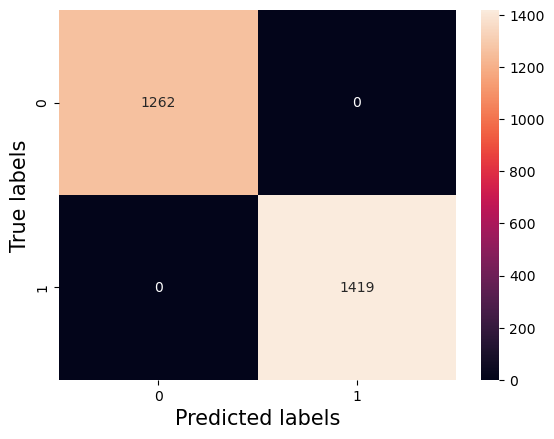

In [11]:
# Compute the accuracy of the predicted classes & the confusion matrix

# acc = ...
# confmat = ...


# YOUR CODE HERE
#raise NotImplementedError()
acc = accuracy_score(y_test, y_pred)
confmat = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)

# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()

In [12]:
# this cell is for tests


In [13]:
# this cell is for tests

You can see that the accuracy of the classifier is high. This could indicate that our data is "good" in the sense that it is easily separable. It could also be a symptom of overfitting. To alleviate the effect of overfitting, we could for example use ensemble methods such as random forests (see lecture slides for details).

Finally, we can plot the decision tree. The tree is also saved as a pdf `mushroom_tree.pdf` for a higher resolution image. Take a look at the tree and answer the questions below.

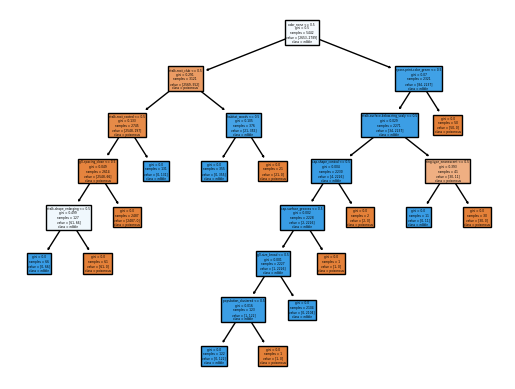

True

In [14]:
plot_tree(clf, feature_names = list(X.columns),  filled = True, class_names=["poisonous", "edible"])
plt.show()

# save as pdf for a high res image:
import pydotplus
d_tree = export_graphviz(clf, feature_names = list(X.columns), filled = True, class_names=["poisonous", "edible"])
pydot_graph = pydotplus.graph_from_dot_data(d_tree)
pydot_graph.write_pdf('mushroom_tree.pdf')

<div class=" alert alert-warning">

## Student Task A3.3

**Q1:** You are stranded in a forest, starving and spot a mushroom nearby. Upon closer inspection, you find that it smells and its stalk is shaped like a club. Based on our decision tree that you happen to have with you, is the mushroom poisonous (Q1 = 0) or edible (Q1 = 1)? Explore the `mushroom_tree.pdf` file or the plotted decision tree to find the answer.
    
    
**Q2:** In the case of classifying mushrooms based on edibility, which would be worse, a false positive (Q2 = 0) or false negative (Q2 = 1) result?

    
</div>

In [15]:
# choose the correct answer

#Q1 = ...
#Q2 = ...


# YOUR CODE HERE
#raise NotImplementedError()
Q1 = 0
Q2 = 0

In [16]:
# this cell is for tests


In [17]:
# this cell is for tests


## Summary

A word of warning: you shouldn't actually eat mushrooms you do not know even if you have a cool decision tree of high accuracy with you. You should only pick edible mushrooms that you are absolutely certain about, preferably taught to you by an expert - so always check before picking!

Possible problems with the decision tree are:
- **Overfitting:** High accuracy could be a symptom of overfitting (the model "memorizes" the data and will perform poorly on samples outside the data).
- **External validation:** We didn't do any external validation for the model - there are no samples outside of this particular dataset to test the accuracy of our classifier on out-of-distribution samples.
- **Data limitations:** The data only considers mushrooms of two families (Agaricus and Lepiota) in North America - naturally the classifier likely doesn't yield correct results for mushrooms of other families or from different geographical locations.



 # Artifical neural networks (ANN)
 
 Being a subset of machine learning (ML) methods, **deep learning** follows the basic ML principle: find a hypothesis map out of a hypothesis space (represented by neural networks) that minimizes a chosen loss on datapoints. 

Neural networks are called networks because they are typically represened by composing together many different functions, and the computed values create a network-like structure. For example, we might have three functions $f^{(1)},f^{(2)}$and $f^{(3)}$ connected in a chain, to form $f(x)=f^{(3)}(f^{(2)}(f^{(1)}))$. In this case, $f{(1)}$is called the first layer of the network, $f^{(2)}$ is called the second layer, and so on. The overall length of the chain gives the depth of the network. Networks with multiple layers are called deep networks, hence the name deep learning.

Typically the final layer is called the **output layer**, and represents the label that we want to predict. The training datapoints "tell" what the output layer must do at each datapoint - it should produce a value that is close to the desired label. The behaviour of other layers however, is not directly specified by the training data. Instead the learning algorithm decides how to use these layers to find the best approximation of the ideal map by minimizing (locally) the loss on the training dataset. Thus, these layers are called **hidden layers**. 
<img src="neural_network.png" alt="neural network" style="width:600px;height:350px;">

In this assignment a fully connected multi-layer neural network, also called feed-forward neural network or **Multilayer Perceptron (MLP)**, is used to represent a hypothesis space that includes highly non-linear functions. MLP is the simplest type of a neural network, where each cell (neuron) is 'connected' to all the cells from the next layer, and only the next layer uses its value.

If you wish to gain understanding of how a neural network actually works and learns, [this video series](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) by 3blue1brown provides a briliant visual explanation.

## Learning goals
After successfully completing this assignment, you should be able to:
* understand the difference of hypothesis maps between MLP and linear models
* understand that activation functions are a key part of neural network design
* train MLPs to complete a regression task
* train MLPs to complete a classification task
* have some basic understanding of gradient based learning of ANN weights
* use grid-search for adjusting multiple MLP hyper-parameters such as number of layers and learning rate parameters

## Basic neural network structure

Take a look at the image below, showing a very basic neural network, with one-element input layer `x` and output layer `y`, and a single hidden layer with 3 hidden units:

![A simple neural network schema](network-schema.png)


The process of calculating the output of the network is as follows. We have the network defined as above, and a bias vector `[bias1, bias2, bias3]` corresponding to the `hidden1, hidden2, hidden3` hidden units. Then:
1. We multiply x with the first layer's weights, and add a constant bias term. We have obtained initial values of the hidden 'neuron' activations. A single value is calculated as:
$$
hidden_i = x * weight_{1i} + bias_i
$$
1. Simply multiplying and adding to the initial value of x would not let us represent any complex non-linear functions, so we need to introduce a non-linearity to our network. It is done via activation functions in the hidden layer, and the most common one is the rectified linear unit (ReLU):
$$
ReLU(x) = max(x, 0)
$$
It could be thought of as a function replacing negative values with 0s. We apply it to our hidden layer activations:
$$
hidden_i = ReLU(hidden_i)
$$
1. Now that we have the activation values, we multiply them with the final weights and sum the result together to obtain the final output:
$$
y = hidden_1 * weight_{21} + hidden_2 * weight_{22} + hidden_3 * weight_{23}
$$

Note that there is no bias in the last step. We also do not use ReLU anymore, as it is a simple regression network. However, for classification, you would use a different activation function for your output to turn it into a probability distribution - see [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) (binary) or [softmax](https://en.wikipedia.org/wiki/Softmax_function) (multiclass)

<div class=" alert alert-warning">
    
## Student Task A3.4
    
Use your understanding of how a neural network works, to set the correct weights and biases for our toy neural network example from above, so that the resulting function `f(x) = y` is a non-linear function looking like this:
![Neural Network hypothesis plot](network-triangle.png)
    
Note that this would not be possible with linear models we studied previously, such as linear regression or SVMs.

The vertices of the triangle must be the points `(0, 0), (1, 1), (2, 0)`. Fill in any missing (`None`) values in the `weights_1`, `weights_2`, or `bias` vectors. There is no need to change the values that have already been set!
    
Hint:  Try it out as a math problem with pen and paper if you have trouble! Try to think what are the already given functions $hidden_1(x)$ and $hidden_3(x)$, what unknowns there are in $hidden_2$, and what is the result of adding them together to obtain $y = f(x) = hidden_1(x) + hidden_2(x) + hidden_3(X)$ - e.g. with the given values:
    
$
hidden_3(x) = 1 * x - 2 
$; for `x > 2`(i.e.`(1*x-2) > 0`)
    
$
hidden_3(x) = 0
$; otherwise
    
There are also visualizations of the intermediate plots below.
<div>

In [25]:
## In the following two lines of code, please fill in the None values in a way allowing you to obtain 
## the given hyphothesis shape.  No need to change the given values in weights_1, bias.

weights_1 = np.array([1., None, 1.])     # a vector represents [w11, w12, w13]
bias = np.array([0., None, -2.])         # a vector represents [bias1, bias2, bias3]

# YOUR CODE HERE
#raise NotImplementedError()
weights_2 = np.array([1, -1, 1])         # a vector represents [w21, w22, w23]

weights_1 = np.array([weights_1[0], 1 ,weights_1[2]])
bias = np.array([bias[0], -2 ,bias[2]])

bias, weights_1


(array([ 0., -2., -2.]), array([1., 1., 1.]))

In [26]:
def hidden(x, weights_1, bias):
    """
    Inputs: x,feature,scalar
            weights_1, vector, [w11,w12,w13]
            bias, vector, [bias1,bias2,bias3]
    Output: activations, vector
    """
    hidden_x = x * weights_1 + bias 
    return np.maximum(hidden_x, 0) # Apply the ReLU activation

def network(x, weights_1, bias, weights_2):
    """
    Inputs: x, feature,scalar
            weights_1, vector, [w11,w12,w13]
            bias, vector, [bias1,bias2,bias3]
            weights_2, vector, [w21,w22,w23]
    Output: predicted label, scalar
    """
    hidden_x = hidden(x, weights_1, bias) # Calculate the hidden activations
    final_x = hidden_x * weights_2 # Multiply them with the final weights [w21, w22, w23]
    return sum(final_x) # Sum the result to obtain the final prediction

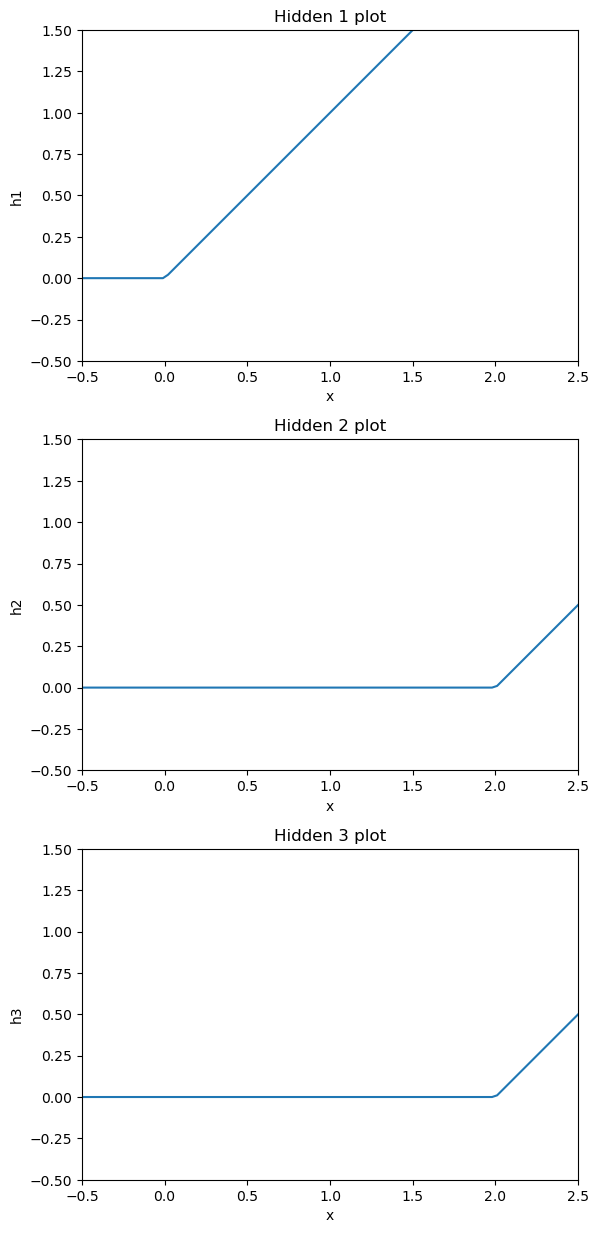

In [27]:
x_to_plot = np.linspace(-0.5, 2.5, 99) # X values to serve as inputs for our network for plotting
plt.figure(figsize=(10, 12))
for i in range(3):
    plt.tight_layout()
    plt.subplot(3, 1, i + 1)
    
    # Compute the hidden layer activations
    hidden_to_plot = [hidden(x, weights_1, bias)[i] for x in x_to_plot]
    
    # Make sure all plots use the same scale
    plt.xlim(-0.5, 2.5) 
    plt.ylim(-0.5, 1.5)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Plot the hidden layer activations
    plt.title(f'Hidden {i + 1} plot')
    plt.xlabel('x')
    plt.ylabel(f'h{i + 1}')
    plt.plot(x_to_plot, hidden_to_plot)

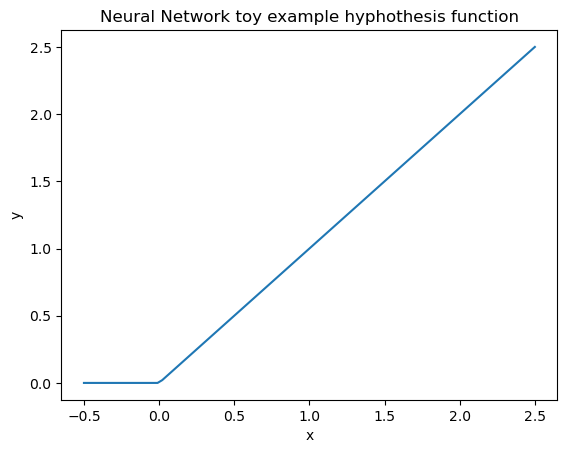

In [28]:
y_to_plot = [network(x, weights_1, bias, weights_2) for x in x_to_plot] # Use our network to obtain y values
plt.title('Neural Network toy example hyphothesis function')
plt.xlabel('x')
plt.ylabel('y')
_ = plt.plot(x_to_plot, y_to_plot)

In [29]:
# Sanity check the resulting values:
assert np.isclose(network(0, weights_1, bias, weights_2), 0.)
assert np.isclose(network(1, weights_1, bias, weights_2), 1.)
assert np.isclose(network(2, weights_1, bias, weights_2), 0.)
assert np.isclose(y_to_plot[0], 0.)
assert np.isclose(y_to_plot[-1], 0.)
assert np.isclose(y_to_plot[len(y_to_plot) // 2], 1.)

AssertionError: 

In [30]:
# this cell is for tests, leave it as it is

In [31]:
# Read in the data stored in the file 'FMIData_Assignment7.csv' and clean the dataset
data = pd.read_csv('FMIData_Assignment7.csv')
# drop unrelevant columns
data.drop(columns=['Time zone','Precipitation amount (mm)','Snow depth (cm)',\
                 'Ground minimum temperature (degC)','Maximum temperature (degC)', 'Minimum temperature (degC)'],inplace=True)  
data.columns =['year','m','d','time','air temperature'] # rename columns 

# Select only weather recordings whose property 'time' is equal to `00:00`
data = data[data['time'] == '00:00']

# Shift the column 'air temperatrue' by different periods to obtain history records
data['pre_1'] = data['air temperature'].shift(1)
data['pre_2'] = data['air temperature'].shift(2)
data['pre_3'] = data['air temperature'].shift(3)
data['pre_4'] = data['air temperature'].shift(4)
data['pre_5'] = data['air temperature'].shift(5)

data = data.iloc[5:] # drop the first 5 rows which involves NAN
data.head()

,year,m,d,time,air temperature,pre_1,pre_2,pre_3,pre_4,pre_5
10,2020,1,6,00:00,1.5,-1.6,1.7,4.6,3.6,1.5
12,2020,1,7,00:00,4.5,1.5,-1.6,1.7,4.6,3.6
14,2020,1,8,00:00,5.3,4.5,1.5,-1.6,1.7,4.6
16,2020,1,9,00:00,2.1,5.3,4.5,1.5,-1.6,1.7
18,2020,1,10,00:00,-2.0,2.1,5.3,4.5,1.5,-1.6


<div class=" alert alert-warning">
    
## Student Task A3.5

In this problem formulation, a datapoint represents a day corresponding to a row in the dataframe. The column "air temperature" stores the labels and columns 'pre_1', 'pre_2', 'pre_3', 'pre_4', 'pre_5' are used as features.
    
Before training an MLP, let's firstly try out the old method we used before: PolynomialRegression. 
    
As usual, we create the feature matrix and label vector and then train several models with different polynomial degrees to see which one is ideal.

**Your task** is: create a feature matrix and a label vector
    
</div>

In [32]:
## Create feature matrix and label vector:
# X = ...      # features are air temperatures of previous 5 days 
# y = ...      # label is air temperature of the present day

# YOUR CODE HERE
#raise NotImplementedError()
features = ['pre_1', 'pre_2', 'pre_3', 'pre_4', 'pre_5']
X = data[features]
y = data['air temperature']

print(X)
print(y.shape)

assert X.ndim == 2,  "Wrong dimension of X"  #sanity check the dimension of X
assert X.shape[1] == 5, "wrong shape of X"  #sanity check the shape of X
assert y.ndim == 1,  "Wrong dimension of y"  #sanity check the dimension of y
assert y.shape[0] == 708, "Wrong shape of y" #sanity check the shape of y

      pre_1  pre_2  pre_3  pre_4  pre_5
10     -1.6    1.7    4.6    3.6    1.5
12      1.5   -1.6    1.7    4.6    3.6
14      4.5    1.5   -1.6    1.7    4.6
16      5.3    4.5    1.5   -1.6    1.7
18      2.1    5.3    4.5    1.5   -1.6
...     ...    ...    ...    ...    ...
1408  -15.4  -14.2  -13.0  -15.0   -8.3
1410   -7.2  -15.4  -14.2  -13.0  -15.0
1412   -2.2   -7.2  -15.4  -14.2  -13.0
1414    0.1   -2.2   -7.2  -15.4  -14.2
1416    1.2    0.1   -2.2   -7.2  -15.4

[708 rows x 5 columns]
(708,)


In [33]:
# this is the test cell, leave it as it is

In [34]:
X_train, X_val,  y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
assert X_train.shape[1] == 5, "Incorrect shape for X_train"

## define a list of values for the maximum polynomial degree 
degrees = [1,2,3,4]    

# we will use this variables to store the resulting training and validation errors for each polynomial degree
linear_tr_errors = []          
linear_val_errors = []
for degree in degrees:    # use for-loop to fit polynomial regression models with different degrees
    lin_regr = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
    poly = PolynomialFeatures(degree=degree)    # generate polynomial features
    X_train_poly = poly.fit_transform(X_train)    # fit the raw features
    lin_regr.fit(X_train_poly, y_train)    # apply linear regression to these new features and labels
  
    y_pred_train = lin_regr.predict(X_train_poly)    # predict using the linear model
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    X_val_poly = poly.transform(X_val) # transform the raw features for the validation data 
    y_pred_val = lin_regr.predict(X_val_poly) # predict values for the validation data using the linear model 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
 
    linear_tr_errors.append(tr_error)
    linear_val_errors.append(val_error)

In [36]:
# create a table to compare training and validation errors
errors = {"poly degree":degrees,
          "linear_train_errors":linear_tr_errors,
          "linear_val_errors":linear_val_errors,
         }
pd.DataFrame({ key:pd.Series(value) for key, value in errors.items()})

,poly degree,linear_train_errors,linear_val_errors
0,1,3.947190,5.547871
1,2,3.789401,5.444261
2,3,3.344839,5.818018
3,4,2.679989,18.741724


<div class=" alert alert-warning">

## Student Task A3.6

Answer the following quiz questions by setting the corresponding variable to the index of the answer that you consider correct. 
    
Question 1: Which of the models from A3.5 would you recommend based on the above table?
- Answer 1: Degree 1
- Answer 2: Degree 2
- Answer 3: Degree 3
- Answer 4: Degree 4
    

</div>

In [37]:
## set Answer_Q1 to the index (starting from 1 !!!) of the correct answer (e.g., Answer_Q1=1 if you think Answer 1 is correct)
# Answer_Q1  = ...  

# YOUR CODE HERE
#raise NotImplementedError()

Answer_Q1 = 2

print("my answer is: ", Answer_Q1)

my answer is:  2


In [38]:
# sanity check datatype of Answer_Q1
assert Answer_Q1 in (1, 2, 3, 4), "Please answer with a number from 1 to 4"

In [39]:
# this cell is for tests, leave it as it is

<div class=" alert alert-warning">

## Student Task A3.7

Now, we know the performance of polynomial regression on this prediction task. It is time to try out MLP and see whether MLP can defeat polynomial regression or not.

We will still focus on Sklearn library and use Sklearn class [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) to implement our model, but for complicated modern deep learning tasks, Python provides other easy-to-use libraries for the design and training of ANN, such as [Keras](https://keras.io/).


**Hypothesis Space used in this task - MLP Structure:**
- one input layer consists of the individual features (5 features) and is the entry point to the MLP.
- several hidden layers with 15 neuron units in each layer and [ReLU activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), we will explore the number of hidden layers in this task, find out the ideal number of hidden layers for this given ML problem.

- one final output layer with 1 neuron unit.

For regularization strength and learning rate, default values are used.

**Loss used in this task**: MSE

In the following solution cell, you will:
- Initialise an MLPRegressor, please use the `hidden_layer_sizes` defined for you and set `max_iter` to 1000, `random_state` to 42.
- Train the regressor on the training set.
- Evaluate the regressor on the training set and validation set.
</div>

In [40]:
from sklearn.neural_network import MLPRegressor

## define a list of values for the number of hidden layers
num_layers = [1,2,4,6,8,10]    # number of hidden layers
num_neurons = 15  # number of neurons in each layer


# we will use this variable to store the resulting training errors corresponding to different hidden-layer numbers
mlp_tr_errors = []          
mlp_val_errors = []

for i, num in enumerate(num_layers):
    hidden_layer_sizes = tuple([num_neurons]*num) # size (num of neurons) of each layer stacked in a tuple
    
    # mlp_regr = ... # Initialise an MLPRegressor
 
    # mlp_regr.fit(...,...)    # Train MLP on the training set
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    mlp_regr = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes, max_iter = 1000, random_state = 42)
    mlp_regr.fit(X_train, y_train)
    
    
    ## evaluate the trained MLP on both training set and validation set
    y_pred_train = mlp_regr.predict(X_train)    # predict on the training set
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = mlp_regr.predict(X_val) # predict values for the validation data 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
    
    # sanity check num of layers
    assert mlp_regr.n_layers_ == num_layers[i]+2 # total layers = num of hidden layers + input layer + output layer
    # sanity check the error values
    assert 3 < tr_error < 4 and 5 < val_error < 6
    
    mlp_tr_errors.append(tr_error)
    mlp_val_errors.append(val_error)

# sanity check the length of array mlp_tr_errors
assert len(mlp_tr_errors) == len(mlp_val_errors) == len(num_layers)
print(mlp_tr_errors)

[3.7489094439046653, 3.619270538941888, 3.523817650546987, 3.6846360916156553, 3.8807597540060343, 3.014632935554798]


In [41]:
# this cell is for tests, leave it as it is


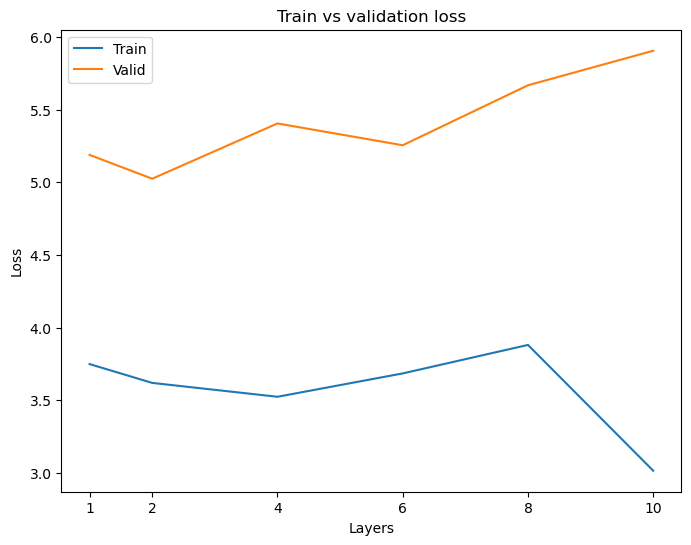

In [42]:
plt.figure(figsize=(8, 6))

plt.plot(num_layers, mlp_tr_errors, label = 'Train')
plt.plot(num_layers, mlp_val_errors,label = 'Valid')
plt.xticks(num_layers)
plt.legend(loc = 'upper left')

plt.xlabel('Layers')
plt.ylabel('Loss')
plt.title('Train vs validation loss')
plt.show()

In [43]:
# create a table to compare the training and validation errors for MLPs with different number of hidden layers
errors = {"num_hidden_layers":num_layers,
          "mlp_train_errors":mlp_tr_errors,
          "mlp_val_errors":mlp_val_errors,
         }
pd.DataFrame(errors)

,num_hidden_layers,mlp_train_errors,mlp_val_errors
0,1,3.748909,5.189208
1,2,3.619271,5.025214
2,4,3.523818,5.405671
3,6,3.684636,5.255682
4,8,3.880760,5.668580
5,10,3.014633,5.906500


<div class=" alert alert-warning">

## Student Task A3.8

Answer the following quiz questions by setting the corresponding variable to the index of the answer that you consider correct. 
    
Question 1: Which of the models from A3.6 would you recommend based on the table above?
- Answer 1: 1 hidden layer MLP
- Answer 2: 2 hidden layers MLP
- Answer 3: 4 hidden layers MLP
- Answer 4: 6 hidden layers MLP
- Answer 5: 8 hidden layers MLP
- Answer 6: 10 hidden layers MLP 
    

</div>

In [44]:
## set Answer_Q1 to the index (starting from 1 !!!) of the correct answer (e.g., Answer_Q1=1 if you think Answer 1 is correct)
# Answer_Q1  = ...  

# YOUR CODE HERE
#raise NotImplementedError()
Answer_Q1 = 2

print(f"my answer is: Answer {Answer_Q1}")

my answer is: Answer 2


In [45]:
# sanity check datatype of Answer_Q1
assert Answer_Q1 in (1, 2, 3, 4, 5, 6), "Please answer with a number 1-6"

In [46]:
# this cell is for tests, leave it as it is

In [47]:
l_errors = {"poly degree":degrees,"linear_train_errors":linear_tr_errors, "linear_val_errors":linear_val_errors,}
print("training errors and validation errors of PolynomialRegression")
pd.DataFrame(l_errors).style.map(lambda x: "background-color: yellow" if x==np.max(linear_val_errors) else "background-color: white")

training errors and validation errors of PolynomialRegression


,poly degree,linear_train_errors,linear_val_errors
0,1,3.947190,5.547871
1,2,3.789401,5.444261
2,3,3.344839,5.818018
3,4,2.679989,18.741724


In [48]:
m_errors = {"mlp_train_errors":mlp_tr_errors, "mlp_val_errors":mlp_val_errors}
print("training errors and validation errors of MLP")
pd.DataFrame(errors).style.map(lambda x: "background-color: yellow" if x==np.max(mlp_val_errors) else "background-color: white")

training errors and validation errors of MLP


,num_hidden_layers,mlp_train_errors,mlp_val_errors
0,1,3.748909,5.189208
1,2,3.619271,5.025214
2,4,3.523818,5.405671
3,6,3.684636,5.255682
4,8,3.880760,5.668580
5,10,3.014633,5.906500


**PolynomialRegression vs MLP**

The tables above compare the performance of PolynomialRegression and MLP on this specific ML problem. We can see that their performances are similar, but MLP is a bit better than PolynomialRegression. Considering sampling randomness, this suggests that deep learning methods are not always undisputed winners, particularly for simpler tasks where a simple model would train faster, predict quicker, and achieve comparable results.

However, one significant advantage of MLP, even for simple problems, is that it is much less sensitive to model complexity than regression, so even without careful hyperparameter tuning the network always somehow 'does the job for us' with decent validation errors ~5, while regression explodes with an error of 18+ when we use a too complex model (max poly degree=4).